In [14]:
%matplotlib widget
from reconstruction import reconstruct_vols_from_imgs
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, recording_to_overlay_preview, showvid, get_lenses, array3d_to_video
from widgets import get_mask_widget, ortho_views_widget, play_video_widget
cmap = "gray"

In [15]:
pn_psf = r"Y:/hpc/r/lfm2025/psfs"
pn_psfs = r"~/hpc-rw/lfm/psfs" 
includes = [''] 
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_psfs, '*'))), reverse=True) if os.path.exists(os.path.join(pn_psfs, rec, 'psf.h5'))] 
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])] 
print('\n'.join(recs))

20250819_1203_PSF_LB_25x_5fps
20250813_1750_PSF_LB_25x_3fps
20250730_1431_PSF_LB_redFB_noap_25x
20250701_1216_PSF_LB_noap_old
20250701_1216_PSF_LB_noap_1
20250610_1636_PSF_LB_30k_wo_coverslip_1
20250530_1330_PSF_LB_redFB_1-30K_dim_isolated
20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3


In [16]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in sorted(pathlib.Path(os.path.expanduser(pn_bg)).iterdir()):
    if file.is_file() and file.suffix == '.npy':
        print(file.name)

20250602_1749_LB_bg_100s.npy
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250602_1753_LB_bg_200s.npy
20250602_1753_LB_bg_200s_100laser_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250611_1508_LB_40fps_100laser_bg.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.npy
20250701_1651_LB_bg_40fps.npy
20250701_1654_LB_bg_2fps.npy
20250729_1146_LB_DC1_5dpf_backfill_1_bg.npy
20250729_1200_LB_DC1_5dpf_backfill_bg_wap_40fps.npy
20250729_1233_LB_DC4_5dpf_backfill_bg_2fps.npy
20250729_1600_LB_DC8_5dpf_backfill_bg_2fps.npy
20250729_1605_LB_DC8_5dpf_backfill_bg_2.npy
20250730_1553_LB_25x_5fps_bg.npy
20250731_1654_LB_redFB_25x_2_bg.npy
20250813_1721_psf_2fps_bg.npy
20250813_1729_psf_4fps_bg.npy
20250813_1730_psf_3fps_bg.npy
20250814_1645_LB_80fps_bg.npy
20250814_1646_LB_40fps_bg.npy
20250815_1937_LBKK_backfill_25x_zf5499i_1_10fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_20fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_40fps_bg.n

In [17]:
# pn_rec = r"Y:/hpc/r/lfm2025/recordings"
pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
includes = ['']
excludes = ["bg"]

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'data.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250818_2304_LB_zf552_25x_f5_audiostim_40fps_1
20250818_2300_LB_zf552_25x_f5_audiostim_40fps_1
20250818_2255_LB_zf552_25x_f5_audiostim_40fps_2
20250818_2252_LB_zf552_25x_f5_audiostim_75fps_2
20250818_2247_LB_zf552_25x_f5_audiostim_75fps_1
20250818_2232_LB_zf552_25x_f4_audiostim_75fps_1
20250818_2228_LB_zf552_25x_f4_audiostim_40fps_1
20250818_2208_LB_zf552_25x_f3_audiostim_40fps_3
20250818_2204_LB_zf552_25x_f3_audiostim_40fps_2
20250818_2159_LB_zf552_25x_f3_audiostim_40fps_1
20250818_2152_LB_zf552_25x_f3_audiostim_75fps_2
20250818_2146_LB_zf552_f25x_f3_audiostim_75fps_1
20250818_2117_LB_zf552_f25x_f2_audiostim_40fps_2
20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1
20250818_2107_LB_zf552_f25x_f2_audiostim_75fps_2
20250818_2102_LB_zf552_f25x_f2_audiostim_75fps_1
20250818_2035_LB_zf552_f25x_f1_audiostim_75fps_2
20250818_2030_LB_zf552_f25x_f1_audiostim_75fps_1
20250818_2026_LB_zf552_f25x_f1_audiostim_40fps_4
20250818_2021_LB_zf552_f25x_f1_audiostim_40fps_3
20250818_2016_LB_zf552_f25x_f1_

In [102]:
import i_o
importlib.reload(i_o)
from i_o import Paths

pn_psfs = r"~/hpc-rw/lfm/psfs"
# pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250818_2107_LB_zf552_f25x_f2_audiostim_75fps_2"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [66]:
psf_f = lazyh5(paths.psf)
crop = np.array(psf_f["crop"])
mask = np.array(psf_f["circle_mask"][crop[0]:crop[1],crop[2]:crop[3]])
psf = np.array(psf_f["psf"])
zpos=np.array(psf_f["z_positions"])

print(psf.shape)

# fig, ax = plt.subplots(1,1,figsize = (7,7))
# ax.imshow(create_projection_image(psf, scalebar=200,zpos=zpos, text= "raw PSF", text_size=4), cmap='gray')
# ax[1].imshow(create_projection_image(psf["psf"]-bg,np.max,pad=10), cmap='binary')

(300, 2048, 2048)


20250818_2117_LB_zf552_f25x_f2_audiostim_40fps_2


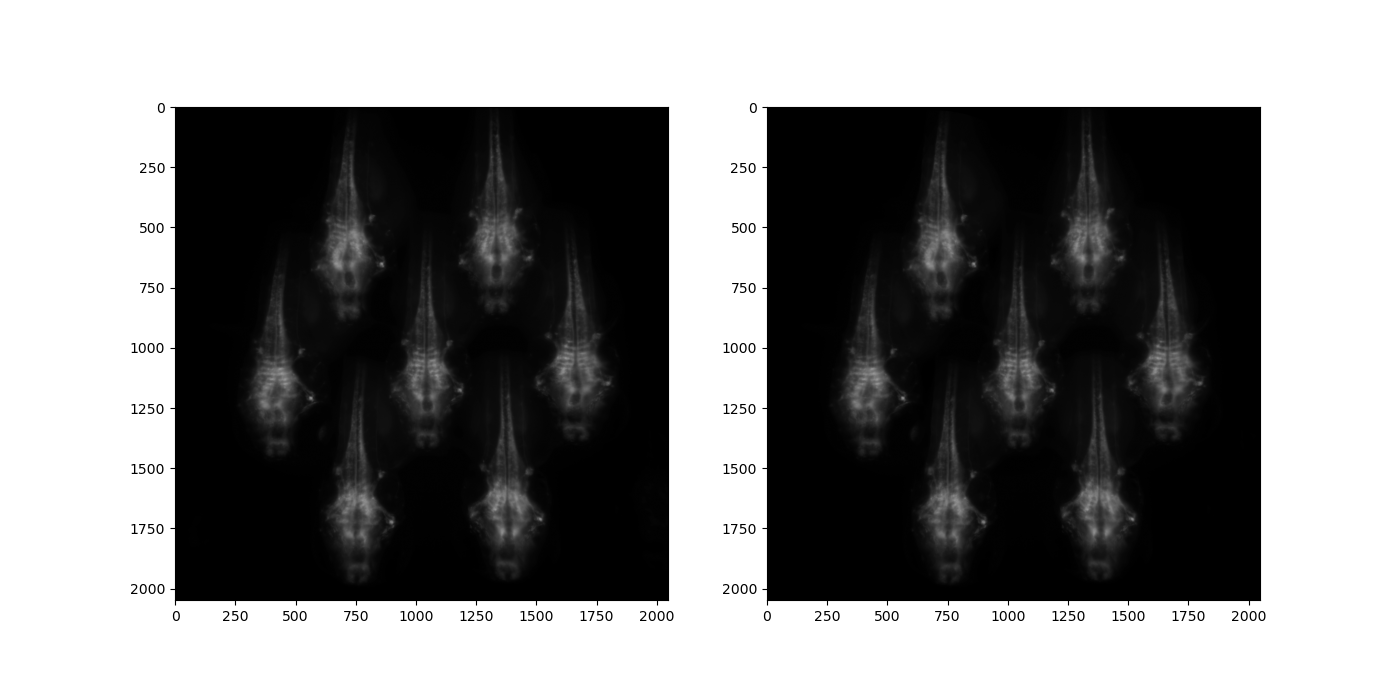

In [67]:
vmax=100


fig, ax = plt.subplots(1,2,figsize = (14,7))
bg = lazyh5(paths.bg)["data"][crop[0]:crop[1],crop[2]:crop[3]]
with h5py.File(paths.raw, "r") as f:
    ims = np.array(f["data"][25:50,crop[0]:crop[1],crop[2]:crop[3]])
im = ims[0]

ax[0].imshow(im, cmap = "gray",vmax=vmax)
ax[1].imshow((im-bg)*mask, cmap="gray",vmax=vmax)
print(dataset_name)

(0.0, 100000.0)

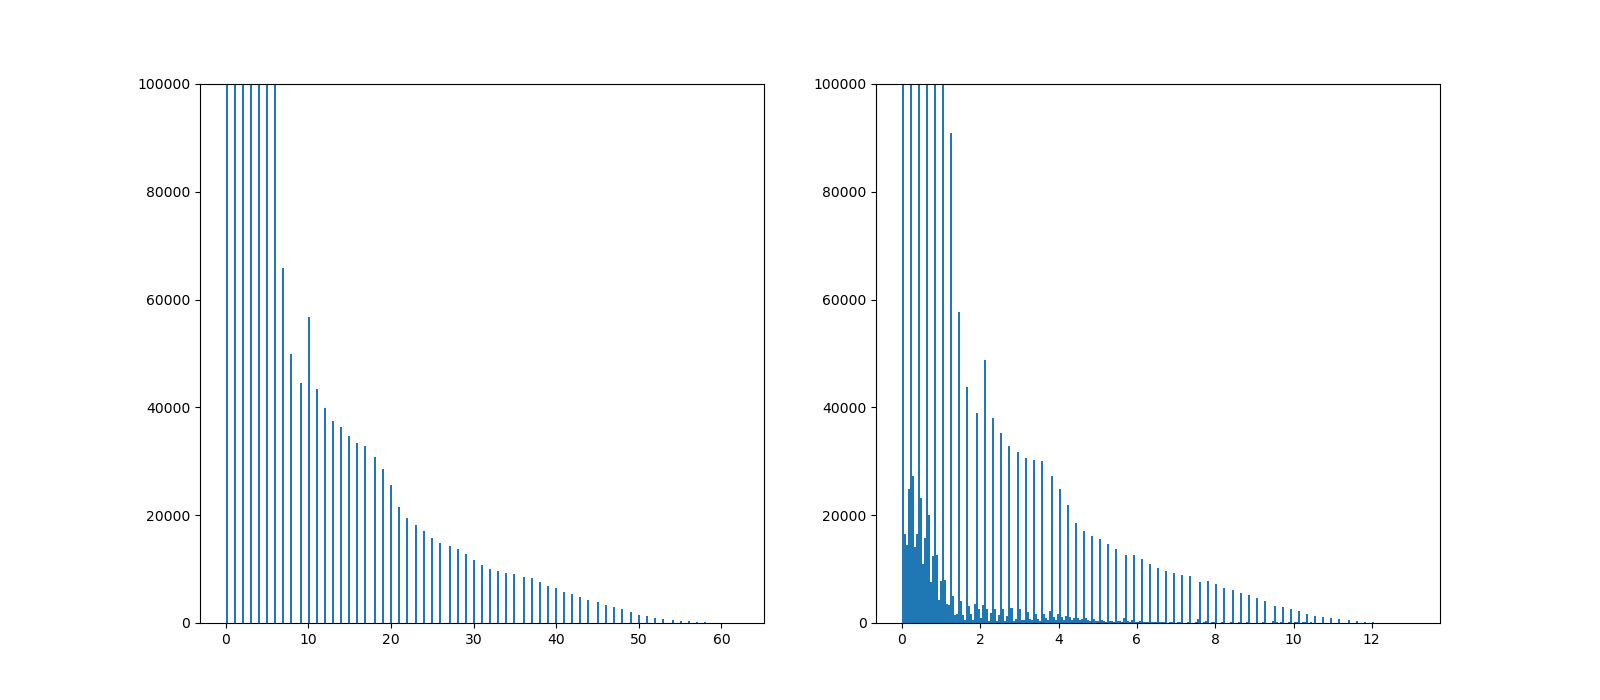

In [68]:
def normalize_mean(arr):
    return arr/arr.mean()
fig, ax = plt.subplots(1,2,figsize = (16,7))
ax[0].hist(im.flatten(),bins=255)
ax[0].set_ylim(0,100000)
ax[1].hist(normalize_mean(((im-bg).clip(0,None)*mask).flatten()),bins=255)
ax[1].set_ylim(0,100000)


In [75]:
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs
img_idx = [25,26,1]
# print(f"PSF zspacing: {np.abs(np.diff(psf["z_positions"][::2])).mean()*1000} um")
objs, mips, losses, kwargs = reconstruct_vols_from_imgs(paths,
                                                        img_idx=img_idx,
                                                        crop = crop,
                                                        max_iter = 50,
                                                        roi_size=500,
                                                        loss_threshold=0,
                                                        reuse_prev_vol = False,
                                                        psf_downsample = [70,205,1],
                                                        OTF_normalize=True,
                                                        OTF_clip=False,
                                                        img_subtract_bg=True,
                                                        img_mask=True,
                                                        img_normalize=True,
                                                        plot_decon=True,
                                                        fully_batched=False,
                                                        projection="max",
                                                        slice_idx=[35,428,609],
                                                        vmin=0,
                                                        vmax=3,
                                                        absolute_limits=True)


Loading PSF, Calculating OTF


Calculating OTF: (downsampling PSF by 1):   0%|          | 0/135 [00:00<?, ?it/s]

Reconstructing volumes:   0%|          | 0/1 [00:00<?, ?it/s]

Deconvolving image 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

In [76]:
import video

importlib.reload(video)
from video import array3d_to_video
fn_vid = os.path.join(paths.pn_outrec , f"deconv_mips_{kwargs["vmin"]}-{kwargs["vmax"]}{'_al' if kwargs["absolute_limits"]else''}.mp4")
array3d_to_video(mips[0], fn_vid)
print("test")
play_video_widget(fn_vid)

Creating video:   0%|          | 0/50 [00:00<?, ?it/s]

test


In [77]:
import widgets
importlib.reload(widgets)
from widgets import ortho_views_widget
ortho_views_widget(objs[0], vmin=0, vmax=10, gpu=False)

OrthoViewsWidget(coords=[64, 496, 496], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

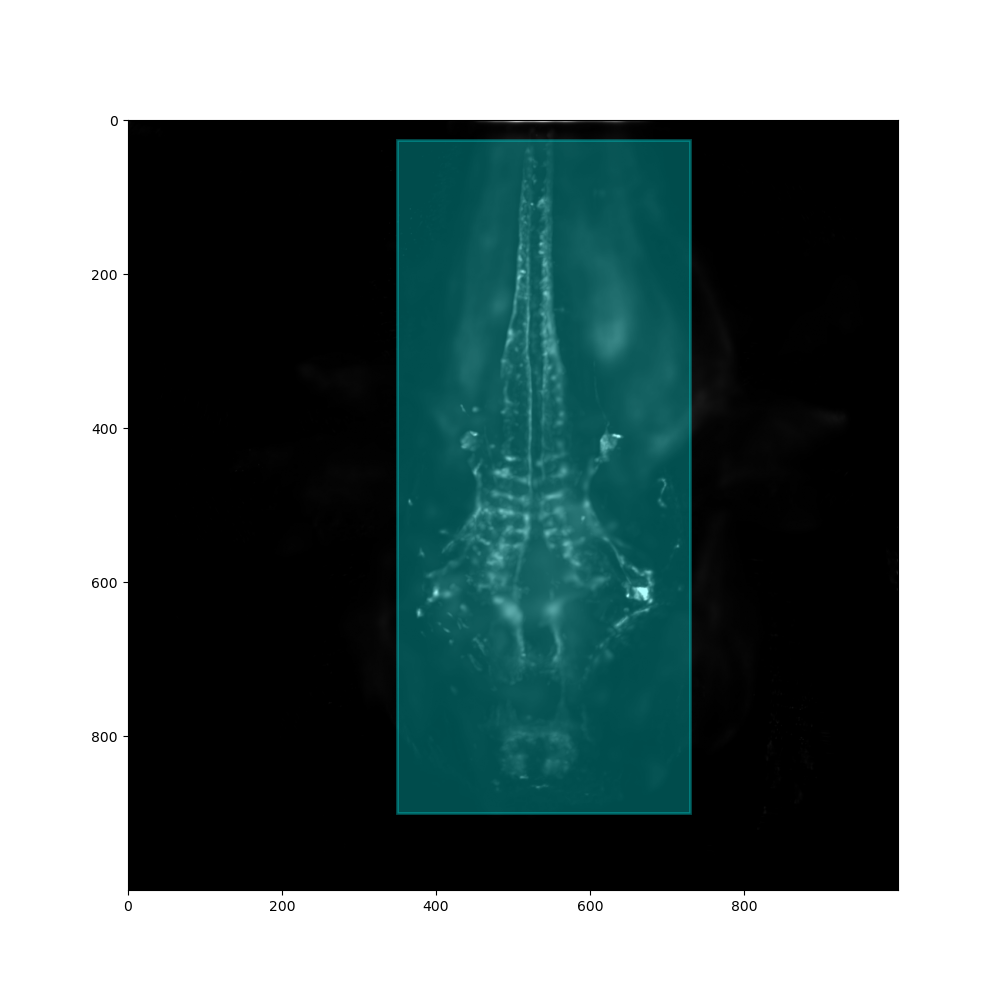

In [81]:
x1, y1 = 350, 25 #top left
x2, y2 = 730, 900 #bottom right
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(objs[0].max(axis=0), cmap = "gray", vmax=4)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)
out_crop = (y1,y2,x1,x2)
kwargs["out_crop"] = out_crop

In [82]:
# kwargs["vmax"] = 3
kwargs["transpose"]=True
kwargs

{'max_iter': 50,
 'xy_pad': 201,
 'roi_size': 500,
 'loss_threshold': 0,
 'reuse_prev_vol': False,
 'psf_downsample': [70, 205, 1],
 'OTF_normalize': True,
 'OTF_clip': False,
 'crop': array([   0, 2048,    0, 2048]),
 'img_subtract_bg': True,
 'img_mask': True,
 'img_normalize': True,
 'fully_batched': False,
 'projection': 'max',
 'slice_idx': [35, 428, 609],
 'vmin': 0,
 'vmax': 3,
 'absolute_limits': True,
 'transpose': True,
 'out_crop': (25, 900, 350, 730)}

## Deconvolve the whole recording

In [33]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel
kwargs, save_fn, vid_fn = reconstruct_vols_from_imgs_parallel(paths,img_idx=None,write_mip_video=True,**kwargs)
# print(save_fn,"\n",vid_fn)


Loading OTF from disk
Setting up I/O queues
Writing into new file: /home/lubo12/hpc-rw/lfm/results/20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1/deconvolved.h5
GPU 0: Initializing Memory


GPU 0: Deconvolving image 1/7219:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-12 (gpu_worker_loop), stopped 23126296811264)>>
Traceback (most recent call last):
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/threading.py", line 1032, in _bootstrap
    self._bootstrap_inner()
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/threading.py", line 1077, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/threading.py", line 1391, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/z

Error in GPU worker 0: 
Traceback (most recent call last):
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/tqdm/notebook.py", line 262, in update
    return super().update(n=n)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/tqdm/std.py", line 1242, in update
    self.refresh(lock_args=self.lock_args)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/tqdm/notebook.py", line 157, in display
    pbar.value = self.n
    ^^^^^^^^^^
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-

In [100]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel

email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='deconv'+paths.dataset_name, conda_env='lfm1',
                                     time="1-00:00", partition="pgpu", gres="gpu:4", cpus_per_task=16,mem='128G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [101]:
job_id = slex.submit(reconstruct_vols_from_imgs_parallel, paths, **kwargs, verbose=2)
print(paths.dataset_name)

Submitted batch job 6085400

20250818_2159_LB_zf552_25x_f3_audiostim_40fps_1


In [104]:

reg = lazyh5(paths.deconvolved)
kwargs = dict(reg["deconvolution_params"])
# kwargs.pop("OTF")
kwargs

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

## Setup registration

In [37]:
importlib.reload(reconstruction)
from reconstruction import percentile_normalization
percentile_normalization(np.arange(20), low_percentile=0, high_percentile=100)
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
ref_vol_idx=[0,10,1] #should have no movement
fn_raw_ref_vid = os.path.join(paths.pn_outrec, "ref_raw.mp4")


ref_vid_writer = AVWriter2(, fps=10, expected_indeces=range(*ref_vol_idx))
ref_reader = VolumeReader(paths.raw, "data", ref_vol_idx)
for i, frame in ref_reader:
    font, lineType = cv2.FONT_HERSHEY_PLAIN, text_size+1
        text_width, text_height = cv2.getTextSize(text, font, text_size, lineType)[0]
    frame =cv2.putText(frame, f"f{i}", 
                             org=10, 
                             fontFace=font,
                             fontScale=text_size, 
                             color = color,
                             thickness=lineType)   


In [ ]:
test_reg_idx=[100, 120] #ideally has movement

In [ ]:
result.deconvolution_params["OTF"]

In [ ]:
import video
importlib.reload(video)
from video import recording_to_video
video_fn = recording_to_video(paths, fps=40, vmax=15, absolute_limits=True)
#it took 1:20:00

Creating video:   0%|          | 0/4020 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import cupy as cp
cp.array([1,0,1],dtype=bool)

array([ True, False,  True])

In [ ]:

import video
importlib.reload(video)
import i_o
importlib.reload(i_o)
from video import recording_to_video, array3d_to_video
import time
start = time.time()
# video_fn = recording_to_video(paths, fps=40, vmax=20, absolute_limits=True)
print("it took", time.time()-start)

it took 2.384185791015625e-05


In [ ]:
# cx, cy, radii, masks = get_lenses(og_mask, radius_range=np.arange(525,535))
cx=np.array(psf_f["ml_cx"])
cy=np.array(psf_f["ml_cy"])
radii=np.array(psf_f["ml_radii"])
masks=np.array(psf_f["ml_masks"])

import video
importlib.reload(video)
from video import recording_to_overlay_preview, get_lenses, img_to_overlay_preview, showvid, get_projection_image
fn_vid, fn_file ,fn_dff_vid, fn_dff_file = recording_to_overlay_preview(paths,
                                                      cx,cy,padxy=300,masks=masks, 
                                                      fps=40, 
                                                      avg_method="median", median_avg_window =40, 
                                                      dff=True,
                                                      vmin=0,vmax=100,absolute_limits=False)
showvid(fn_vid)

In [35]:
print(og_crop, og_crop[1]-og_crop[0],og_crop[3]-og_crop[2])
better_crop = os.path.expanduser(os.path.join(pn_psfs, "20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1","psf.h5"))
with h5py.File(better_crop,"r") as f:
    crop = list(f["crop"])
    og_mask=np.array(f["circle_mask"])
print(crop, crop[1]-crop[0],crop[3]-crop[2])
plt.imshow(og_mask[crop[0]:crop[1],crop[2]:crop[3]])


NameError: name 'og_crop' is not defined

In [ ]:
crop[0]=crop[0]-1
crop[2]=crop[2]-1
print(crop, crop[1]-crop[0],crop[3]-crop[2])
mask = og_mask[crop[0]:crop[1],crop[2]:crop[3]]

Creating video:   0%|          | 0/100 [00:00<?, ?it/s]

'/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/testmip/deconv_f25_roi500_img_masked_vmin0_vmax5_al_OTF_20250701_1216_PSF_LB_noap_1_pad201_norm_dwn[60, -30, 1].mp4'

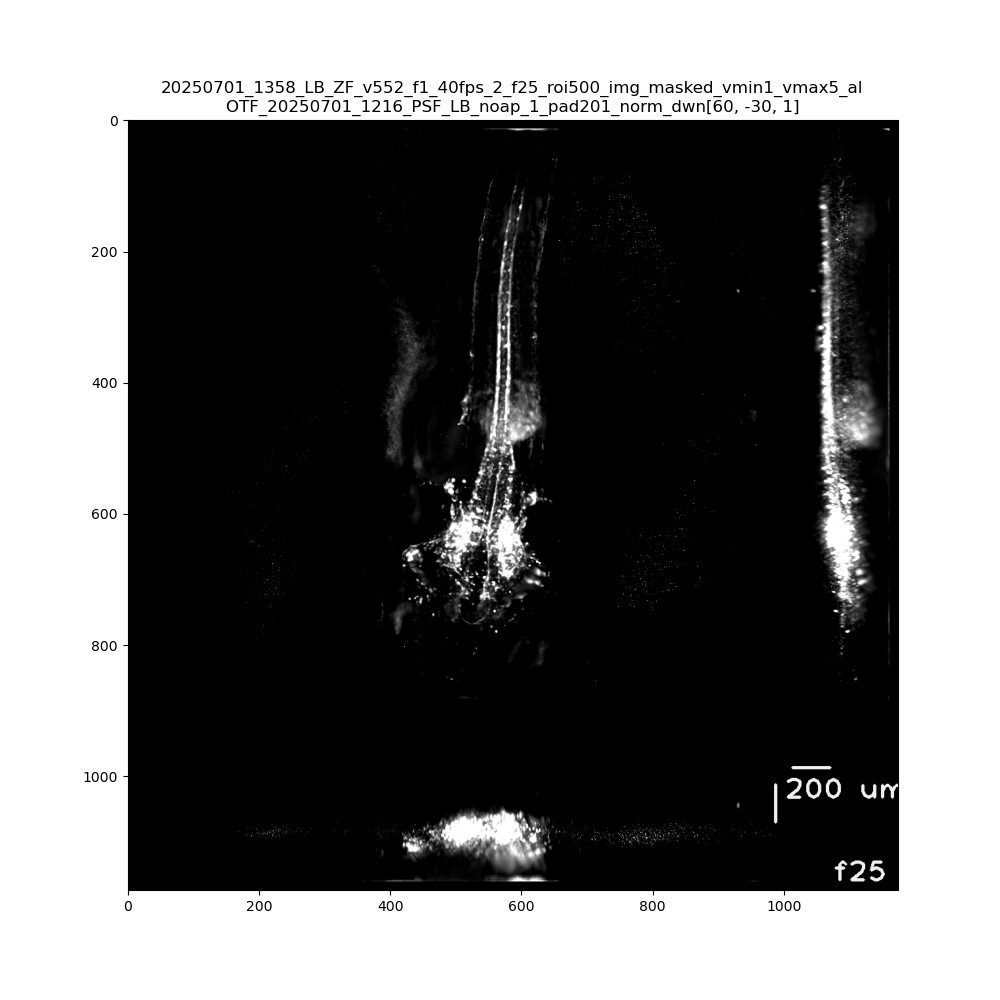

In [ ]:
import video
importlib.reload(video)

from video import create_projection_image, array3d_to_video

frame = 0

vmin=1
vmax=5
absolute_limits=True
_zpos = zpos[kwargs["psf_downsample"][0]:kwargs["psf_downsample"][1]:kwargs["psf_downsample"][2]] if kwargs["psf_downsample"] is not None else zpos


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(create_projection_image(objs[0], vmin=vmin, vmax=vmax, absolute_limits=absolute_limits, zpos = _zpos, scalebar=200, text = f"f{np.arange(*img_idx)[frame]}",),cmap = "gray")

title = f"f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{vmin}_vmax{vmax}{"_al" if absolute_limits else ""}"
deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"

ax.set_title(paths.dataset_name+"_"+title +"\n"+otf_name)
os.mkdir(os.path.join(paths.pn_outrec,"testmip")) if not os.path.exists(os.path.join(paths.pn_outrec,"testmip")) else None
fig.savefig(os.path.join(paths.pn_outrec,"testmip",f"{title}_{otf_name}.png"))

deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"


array3d_to_video(mips[0],  os.path.join(paths.pn_outrec,"testmip",f"{deconv_title}_{otf_name}.mp4")) # doesnt change the vmax in the vid. redo the deconvolution to update this one